# CIFAR-10: Data Augmentation y Arquitecturas Avanzadas

En esta notebook, exploraremos técnicas de **data augmentation** y el uso de **arquitecturas avanzadas** como DenseNet para mejorar el rendimiento de modelos de clasificación en el dataset CIFAR-10. Abordaremos también los desafíos de las redes CNN tradicionales y cómo las arquitecturas modernas pueden superarlos.

## Introducción

### Objetivos

1. **Implementar y entender técnicas de data augmentation** para aumentar la diversidad del conjunto de entrenamiento y mejorar la generalización de los modelos.
2. **Comparar arquitecturas de redes neuronales** tradicionales con arquitecturas más avanzadas como DenseNet.
3. **Entrenar y evaluar modelos de clasificación** en PyTorch utilizando el dataset CIFAR-10.
4. **Analizar el impacto de las técnicas de data augmentation y las arquitecturas avanzadas** en el rendimiento del modelo utilizando métricas adecuadas.

### Contenido

1. Configuración de bibliotecas y semillas para reproducibilidad.
2. Familiarización con `torchvision.transforms`.
2. Carga y exploración del dataset CIFAR-10.
3. Aplicación de técnicas de data augmentation.
4. Implementación y comparación de modelos CNN tradicionales y DenseNet.
5. Evaluación y comparación del rendimiento de los modelos con y sin data augmentation y utilizando diferentes arquitecturas.

### Sobre el conjunto de datos

El dataset CIFAR-10 es un conjunto de datos muy utilizado en la investigación de la visión por computadora. Contiene 60,000 imágenes de 32x32 píxeles en 10 clases diferentes, con 6,000 imágenes por clase. Este conjunto de datos es ideal para entrenar y evaluar modelos de clasificación, permitiendo explorar la efectividad de diversas técnicas de aumento de datos y arquitecturas avanzadas.

El modelo está disponible en el siguiente [link](https://www.cs.toronto.edu/~kriz/cifar.html), pero PyTorch proporciona una interfaz para descargar y cargar el conjunto de datos de forma sencilla.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as T
from torchvision.io import read_image

from torchinfo import summary

import os
from pathlib import Path
import numpy as np

from utils import (
    train,
    plot_training,
    model_classification_report,
    show_tensor_image,
    show_tensor_images,
)

In [2]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 23

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")

Usando cuda
Usando 4


In [4]:
BATCH_SIZE = 512  # tamaño del batch

## Data Augmentation

El **data augmentation** es una técnica de **regularización** que consiste en aplicar transformaciones aleatorias a las imágenes de entrenamiento, como rotaciones, traslaciones, reflejos, recortes, etc. Esto aumenta la diversidad del conjunto de entrenamiento y ayuda a mejorar la generalización del modelo.

PyTorch proporciona una interfaz sencilla para aplicar data augmentation a través de la clase [`torchvision.transforms`](https://pytorch.org/vision/main/transforms.html). Primero tomemos una imagen de ejemplo y apliquemos algunas transformaciones comunes. 

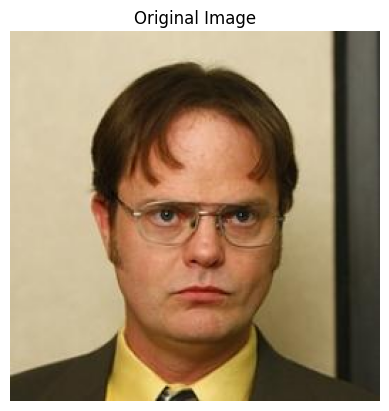

In [5]:
img = read_image(str(Path("assets") / "dwight.jpg"))
show_tensor_image(img, title="Original Image")

Las transformaciones más comunes incluyen:

- [`RandomHorizontalFlip`](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.RandomHorizontalFlip.html): Voltea horizontalmente la imagen con una probabilidad dada.
- [`RandomCrop`](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.RandomCrop.html): Recorta la imagen de forma aleatoria.
- [`RandomRotation`](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.RandomRotation.html): Rota la imagen de forma aleatoria.
- [`ColorJitter`](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.ColorJitter.html): Cambia el brillo, contraste, saturación y tono de la imagen de forma aleatoria.
- [`RandomResizedCrop`](https://pytorch.org/vision/stable/generated/torchvision.transforms.v2.RandomResizedCrop.html): Recorta y cambia el tamaño de la imagen de forma aleatoria.
- ...

Se puede ver la lista completa de transformaciones en la [documentación oficial](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended).

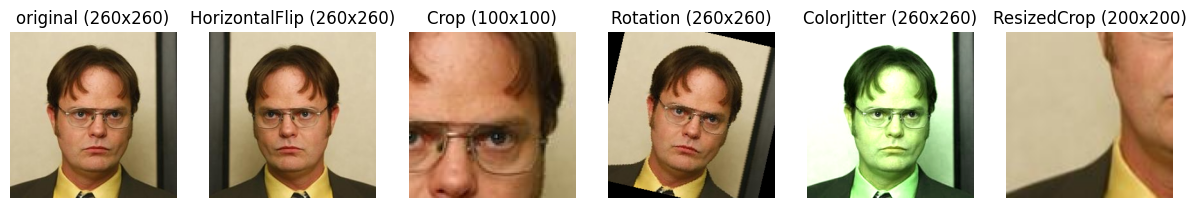

In [6]:
img_rhf = T.RandomHorizontalFlip(p=1)(img)  # p=1 para que siempre se aplique
img_rc = T.RandomCrop(size=(100, 100))(img)  # tomamos un recorte de 100x100
img_rr = T.RandomRotation(degrees=45)(
    img
)  # rotamos la imagen de forma aleatoria entre -45 y 45 grados
img_cj = T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)(
    img
)  # aplicamos un cambio de color
img_rrc = T.RandomResizedCrop(size=(200, 200))(
    img
)  # tomamos un recorte y redimensionamos a 200x200

show_tensor_images(
    [img, img_rhf, img_rc, img_rr, img_cj, img_rrc],
    titles=[
        f"original ({img.shape[-2]}x{img.shape[-1]})",
        f"HorizontalFlip ({img_rhf.shape[-2]}x{img_rhf.shape[-1]})",
        f"Crop ({img_rc.shape[-2]}x{img_rc.shape[-1]})",
        f"Rotation ({img_rr.shape[-2]}x{img_rr.shape[-1]})",
        f"ColorJitter ({img_cj.shape[-2]}x{img_cj.shape[-1]})",
        f"ResizedCrop ({img_rrc.shape[-2]}x{img_rrc.shape[-1]})",
    ],
)

Tamibén se pueden combinar transformaciones utilizando [`Compose`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Compose).

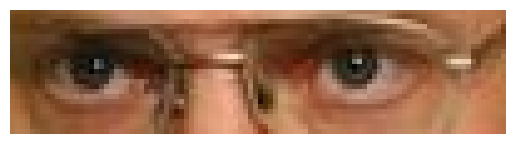

In [7]:
composed = T.Compose([T.RandomHorizontalFlip(p=1), T.CenterCrop(size=(25, 100))])

img_composed = composed(img)
show_tensor_image(img_composed)

En general vamos a aplicar las transformaciones a las imágenes de entrenamiento, pero no a las de validación y test. Por lo tanto, es importante tener dos pipelines de transformaciones, uno para entrenamiento y otro para validación/test.

> Es importante considerar que no todas las transformaciones son adecuadas para todas las tareas. Por ejemplo, en el caso del dataset MNIST, no se debería aplicar `RandomHorizontalFlip` ya que los dígitos perderían su significado al voltearse horizontalmente. De manera similar, usar `RandomVerticalFlip` podría causar problemas con dígitos como el 6 y el 9, que se confundirían al invertirse verticalmente.


## Dataset y DataLoader


### Dataset

El dataset [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) es un conjunto de datos ampliamente utilizado en el campo del aprendizaje automático y la visión por computadora. Contiene 60,000 imágenes a color divididas en 10 clases, tales como aviones, automóviles, pájaros, gatos y perros. Cada imagen es de 32x32 píxeles, lo que lo hace ideal para probar algoritmos de clasificación de imágenes.

Para facilitar el manejo del dataset CIFAR-10, utilizaremos la biblioteca `torchvision.datasets`, la cual proporciona una manera sencilla de cargar y preprocesar estos datos.

### DataLoader

Para facilitar los experimentos y el entrenamiento de modelos vamos a definir una función `get_dataloaders` que nos devolverá los DataLoaders para los conjuntos de entrenamiento, validación y test con las transformaciones deseadas.

In [10]:
DATA_DIR = Path("data")

# Wrapper para aplicar transformaciones
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __len__(self):
        return len(self.subset)
    
    def __getitem__(self, idx):
        image, label = self.subset[idx]
        return self.transform(image), label

def get_dataloaders(
    train_transf, test_transf, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS
):
    """
    Función para obtener los dataloaders de entrenamiento, validación y test

    Args:
    - train_transf: transformaciones para el dataset de entrenaiento
    - test_transf: transformaciones para el dataset de test
    - batch_size: tamaño del batch
    - num_workers: número de workers para cargar los datos
    """

    # descargamos el dataset CIFAR10 (si no lo tenemos ya)
    train_dataset = datasets.CIFAR10(
        DATA_DIR, train=True, download=True, transform=None
    )
    test_dataset = datasets.CIFAR10(
        DATA_DIR, train=False, download=True, transform=test_transf
    )

    # dividimos el dataset de entrenamiento en entrenamiento y validación
    train_size = int(0.8 * len(train_dataset))
    valid_size = len(train_dataset) - train_size
    train_dataset, validation_dataset = random_split(
        train_dataset,
        [train_size, valid_size],
        generator=torch.Generator().manual_seed(SEED),  # fijamos la semilla
    )

    # aplicamos las transformaciones
    train_dataset = TransformDataset(train_dataset, train_transf)
    validation_dataset = TransformDataset(validation_dataset, test_transf)

    # creamos los dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )

    valid_loader = DataLoader(
        validation_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    return train_loader, valid_loader, test_loader

In [8]:
NUM_CLASES = 10  # número de clases en CIFAR10

### Transformaciones

Vamos a definir 3 pipelines de transformaciones:

1. **Transformaciones sin data augmentation**: Estas transformaciones se aplican al conjunto de entrenamiento sin utilizar técnicas de data augmentation. Esto nos proporciona un punto de referencia sobre el rendimiento del modelo con datos sin alterar.
2. **Transformaciones con data augmentation**: Estas transformaciones se aplican al conjunto de entrenamiento utilizando técnicas de data augmentation. La data augmentation ayuda a aumentar la variabilidad de los datos de entrenamiento, mejorando la capacidad del modelo para generalizar.

In [11]:
train_dataset = datasets.CIFAR10(
    DATA_DIR, train=True, download=True, transform=T.Compose([
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
    ])
)

# Stack todas las imágenes en un tensor
data = torch.stack([img for img, _ in train_dataset])
# Shape: (50000, 3, 32, 32)

# Calcula mean y std por canal
T_MEAN = data.mean(dim=[0, 2, 3])  # Promedia sobre samples, height, width
T_STD = data.std(dim=[0, 2, 3])

print(f"Mean: {T_MEAN}")
print(f"Std: {T_STD}")

100%|██████████| 170M/170M [00:11<00:00, 14.6MB/s] 


Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


In [12]:
# Transformaciones con data augmentation
train_transforms_aug = T.Compose(
    [
        # Data augmentation:
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=10),
        # Transformaciones comunes:
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean=T_MEAN, std=T_STD),
    ]
)

# Transformaciones con data augmentation
train_transforms_no_aug = T.Compose(
    [
        # Transformaciones comunes:
        T.ToImage(),
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean=T_MEAN, std=T_STD),
    ]
)


# Transformaciones sin data augmentation
test_transform = T.Compose(
    [
        T.ToImage(),  # tenemos que convertir la imagen PIL a tensor
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(mean=T_MEAN, std=T_STD),
    ]
)

## Parte 1: Data Augmentation

En este experimento, compararemos el rendimiento de un modelo de clasificación de imágenes en el dataset CIFAR-10 con y sin data augmentation. Utilizaremos una arquitectura de red neuronal convolucional tradicional y evaluaremos el rendimiento en términos de precisión y pérdida.

### Modelo base: LeNet

Tomemos [LeNet](https://d2l.ai/chapter_convolutional-neural-networks/lenet.html) para este experimento. LeNet es una red neuronal convolucional simple y nos permitirá comparar el impacto de la data augmentation en un modelo básico.


In [13]:
class LeNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(LeNet, self).__init__()
        self.c1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        self.f6 = nn.Linear(in_features=120, out_features=84)
        self.output = nn.Linear(84, num_classes)

    def forward(self, x):
        x = F.tanh(self.c1(x))
        x = self.s2(x)
        x = F.tanh(self.c3(x))
        x = self.s4(x)
        x = F.tanh(self.c5(x))
        x = x.flatten(start_dim=1)
        x = F.tanh(self.f6(x))
        x = self.output(x)
        return x

summary(LeNet(3, NUM_CLASES), input_size=(BATCH_SIZE, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [512, 10]                 --
├─Conv2d: 1-1                            [512, 6, 28, 28]          456
├─AvgPool2d: 1-2                         [512, 6, 14, 14]          --
├─Conv2d: 1-3                            [512, 16, 10, 10]         2,416
├─AvgPool2d: 1-4                         [512, 16, 5, 5]           --
├─Conv2d: 1-5                            [512, 120, 1, 1]          48,120
├─Linear: 1-6                            [512, 84]                 10,164
├─Linear: 1-7                            [512, 10]                 850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 337.02
Input size (MB): 6.29
Forward/backward pass size (MB): 26.70
Params size (MB): 0.25
Estimated Total Size (MB): 33.24

In [14]:
# definicion de hiperparametros
LR = 0.001
EPOCHS = 30
# definimos
CRITERION = nn.CrossEntropyLoss().to(DEVICE)

### Entrenamiento sin data augmentation

In [15]:
train_loader, val_loader, test_loader = get_dataloaders(
    train_transforms_no_aug, test_transform
)

In [16]:
letnet_model = LeNet(3, NUM_CLASES).to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

Epoch: 001 | Train Loss: 1.93093 | Val Loss: 1.79409
Epoch: 002 | Train Loss: 1.73076 | Val Loss: 1.67829
Epoch: 003 | Train Loss: 1.63273 | Val Loss: 1.59355
Epoch: 004 | Train Loss: 1.53567 | Val Loss: 1.50005
Epoch: 005 | Train Loss: 1.44323 | Val Loss: 1.45235
Epoch: 006 | Train Loss: 1.37789 | Val Loss: 1.37917
Epoch: 007 | Train Loss: 1.32439 | Val Loss: 1.34825
Epoch: 008 | Train Loss: 1.29441 | Val Loss: 1.32167
Epoch: 009 | Train Loss: 1.25001 | Val Loss: 1.30569
Epoch: 010 | Train Loss: 1.22410 | Val Loss: 1.28821
Epoch: 011 | Train Loss: 1.19322 | Val Loss: 1.28050
Epoch: 012 | Train Loss: 1.16451 | Val Loss: 1.27836
Epoch: 013 | Train Loss: 1.14208 | Val Loss: 1.26224
Epoch: 014 | Train Loss: 1.12249 | Val Loss: 1.27778
Epoch: 015 | Train Loss: 1.10521 | Val Loss: 1.25182
Epoch: 016 | Train Loss: 1.08999 | Val Loss: 1.26337
Epoch: 017 | Train Loss: 1.06749 | Val Loss: 1.24638
Epoch: 018 | Train Loss: 1.04554 | Val Loss: 1.24620
Epoch: 019 | Train Loss: 1.03256 | Val Loss: 1

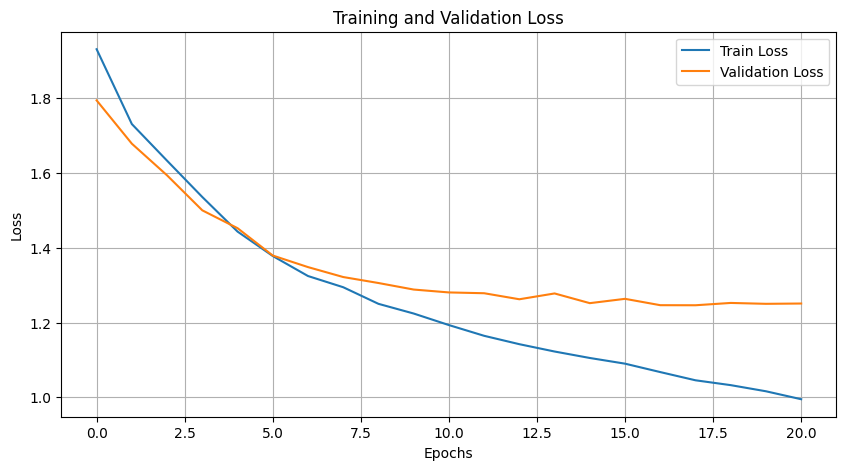

In [17]:
train_errors_ln_nda, val_errors_ln_nda = train(
    model=letnet_model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=3,
    epochs=EPOCHS,
)

plot_training(train_errors_ln_nda, val_errors_ln_nda)

In [18]:
model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.5646

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.62      0.63      0.63      1000
           1       0.67      0.67      0.67      1000
           2       0.44      0.46      0.45      1000
           3       0.39      0.45      0.42      1000
           4       0.51      0.42      0.46      1000
           5       0.51      0.49      0.50      1000
           6       0.64      0.60      0.62      1000
           7       0.63      0.64      0.64      1000
           8       0.64      0.66      0.65      1000
           9       0.61      0.61      0.61      1000

    accuracy                           0.56     10000
   macro avg       0.57      0.56      0.56     10000
weighted avg       0.57      0.56      0.56     10000



### Entrenamiento con data augmentation

In [19]:
letnet_model = LeNet(3, NUM_CLASES).to(DEVICE)
optimizer = optim.Adam(letnet_model.parameters(), lr=LR)

train_loader, val_loader, test_loader = get_dataloaders(
    train_transforms_aug, test_transform
)

Epoch: 001 | Train Loss: 1.94349 | Val Loss: 1.78203
Epoch: 002 | Train Loss: 1.73162 | Val Loss: 1.68061
Epoch: 003 | Train Loss: 1.64207 | Val Loss: 1.59074
Epoch: 004 | Train Loss: 1.55889 | Val Loss: 1.52757
Epoch: 005 | Train Loss: 1.49006 | Val Loss: 1.46133
Epoch: 006 | Train Loss: 1.43579 | Val Loss: 1.42073
Epoch: 007 | Train Loss: 1.39365 | Val Loss: 1.38506
Epoch: 008 | Train Loss: 1.35282 | Val Loss: 1.35385
Epoch: 009 | Train Loss: 1.32609 | Val Loss: 1.33397
Epoch: 010 | Train Loss: 1.29649 | Val Loss: 1.32339
Epoch: 011 | Train Loss: 1.27388 | Val Loss: 1.30967
Epoch: 012 | Train Loss: 1.25368 | Val Loss: 1.29373
Epoch: 013 | Train Loss: 1.23349 | Val Loss: 1.27310
Epoch: 014 | Train Loss: 1.22344 | Val Loss: 1.27643
Epoch: 015 | Train Loss: 1.19559 | Val Loss: 1.25730
Epoch: 016 | Train Loss: 1.18210 | Val Loss: 1.26305
Epoch: 017 | Train Loss: 1.17516 | Val Loss: 1.25033
Epoch: 018 | Train Loss: 1.16274 | Val Loss: 1.24387
Epoch: 019 | Train Loss: 1.15740 | Val Loss: 1

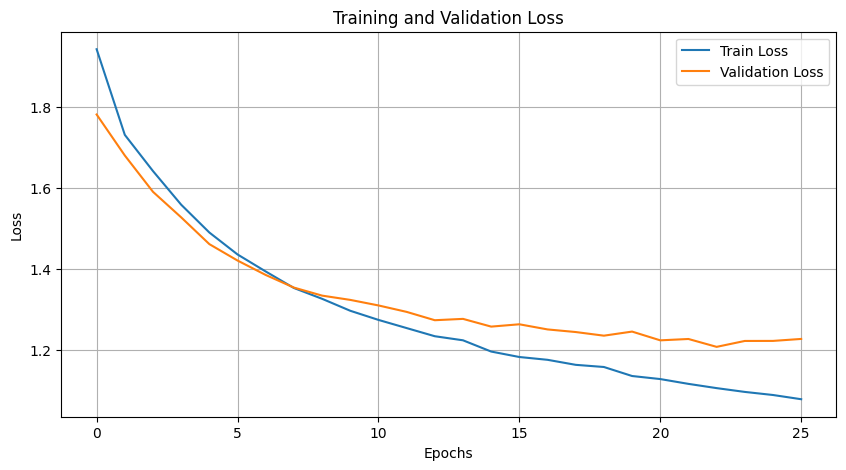

In [20]:
train_errors_ln_da, val_errors_ln_da = train(
    model=letnet_model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=3,
    epochs=EPOCHS,
)

plot_training(train_errors_ln_da, val_errors_ln_da)

In [21]:
model_classification_report(letnet_model, test_loader, DEVICE, NUM_CLASES)

Accuracy: 0.5715

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.63      0.60      0.61      1000
           1       0.66      0.70      0.68      1000
           2       0.46      0.46      0.46      1000
           3       0.43      0.40      0.41      1000
           4       0.63      0.34      0.44      1000
           5       0.48      0.54      0.51      1000
           6       0.59      0.67      0.63      1000
           7       0.69      0.61      0.64      1000
           8       0.66      0.71      0.69      1000
           9       0.53      0.69      0.60      1000

    accuracy                           0.57     10000
   macro avg       0.58      0.57      0.57     10000
weighted avg       0.58      0.57      0.57     10000



### Ejercicios

1. ¿Qué mejoras observas al utilizar data augmentation en este experimento?
2. Experimenta con diferentes transformaciones y evalúa su impacto en el rendimiento del modelo.

In [22]:
# TODO Ej1
# la mejora es muy poca

In [ ]:
# TODO Ej2

## Parte 2: DenseNet

[DenseNet](https://d2l.ai/chapter_convolutional-modern/densenet.html) es una arquitectura de red neuronal convolucional que aborda los problemas de las redes tradicionales conectando cada capa con todas las capas subsiguientes. Esto permite que la información fluya de manera más eficiente a través de la red y facilita el entrenamiento de redes profundas.

Se recomienda leer los articulos:
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) 
- [Densely Connected Convolutional Networks](https://arxiv.org/abs/1608.06993)

### Arquitectura DenseNet

Podemos dividir DenseNet en cuatro partes principales:
- **Convolucion inicial**: Una sola capa convolucional seguida de una capa de pooling. (saca las features mas importantes y disminuye el tamaño de la imagen)
- **Bloques densos**: Varios bloques densos, cada uno compuesto por múltiples capas convolucionales conectadas entre sí. Dentro del bloque, todos tienen el mismo shape, porque los estamos concatenando.
- **Transiciones**: Capas convolucionales que reducen la altura y el ancho de las activaciones. Aca es donde reducimos el shape (se reduce cantidad de canales y tamaño de imagen). Hay un parametro que dice en cuanto voy a reducir los canales acá.
- **Capa de salida**: Una capa de pooling global y una capa completamente conectada.

![Image](https://miro.medium.com/max/5164/1*_Y7-f9GpV7F93siM1js0cg.jpeg)

#### Bloque denso

Los [bloques densos](https://d2l.ai/chapter_convolutional-modern/densenet.html#dense-blocks) son la característica principal de DenseNet. Cada bloque denso conecta cada capa con todas las capas subsiguientes en un patrón denso (de ahí el nombre). Esto permite que la información fluya de manera más eficiente a través de la red y facilita el entrenamiento de redes profundas.

Los bloques densos están compuestos por capas densa que constan de:
- Una capa convolucional.
- Un capa de Batch Normalization.
- Una función de activación ReLU.

Luego en el forward se concatenan la salida con la entrada usando la función [`torch.cat`](https://pytorch.org/docs/stable/generated/torch.cat.html).

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-20_at_11.33.17_PM_Mt0HOZL.png" width="500">

La forma de controlar la cantidad de canales en cada capa es mediante el parámetro `growth_rate`, que indica cuántos canales se agregarán en cada capa convolucional dentro de un bloque denso.

In [25]:
class DenseLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DenseLayer, self).__init__()
        # conv - BN - Relu , es el orden que se da en teorico
        # si hago la relu despues de la conv, muchas neuronas quedaran en 0 entonces lo hacemos al reves

        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(True) # in place para ahorrar un poco de memoria
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) # padding 1 para no cambiar tamaño

    def forward(self, x):
        y = self.conv(self.relu(self.bn(x)))
        return torch.cat([x,y], dim=1) # esto es lo que hace que sea una densenet

In [26]:
in_channels  = 6  # número de canales de entrada
out_channels = 4 # número de canales de salida
dense_layer = DenseLayer(in_channels=in_channels, out_channels=out_channels)
summary(dense_layer, input_size=(BATCH_SIZE, in_channels, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
DenseLayer                               [512, 10, 32, 32]         --
├─BatchNorm2d: 1-1                       [512, 6, 32, 32]          12
├─ReLU: 1-2                              [512, 6, 32, 32]          --
├─Conv2d: 1-3                            [512, 4, 32, 32]          220
Total params: 232
Trainable params: 232
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.35
Input size (MB): 12.58
Forward/backward pass size (MB): 41.94
Params size (MB): 0.00
Estimated Total Size (MB): 54.53

In [27]:
class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.block = []
        for i in range(num_layers):
            self.block += [DenseLayer(in_channels + i * growth_rate, growth_rate)]
        
        self.denseBlock = nn.Sequential(*self.block)

    def forward(self, x):
        return self.denseBlock(x)

In [29]:
in_channels = 6  # número de canales de entrada
num_layer   = 5  # número de capas en el bloque denso
growth_rate = 4  # tasa de crecimiento

dense_block = DenseBlock(num_layer, in_channels, growth_rate)

summary(dense_block, input_size=(BATCH_SIZE, in_channels, 32, 32))

# 26 = in_channels + num_layer * growth_rate

Layer (type:depth-idx)                   Output Shape              Param #
DenseBlock                               [512, 26, 32, 32]         --
├─Sequential: 1-1                        [512, 26, 32, 32]         --
│    └─DenseLayer: 2-1                   [512, 10, 32, 32]         --
│    │    └─BatchNorm2d: 3-1             [512, 6, 32, 32]          12
│    │    └─ReLU: 3-2                    [512, 6, 32, 32]          --
│    │    └─Conv2d: 3-3                  [512, 4, 32, 32]          220
│    └─DenseLayer: 2-2                   [512, 14, 32, 32]         --
│    │    └─BatchNorm2d: 3-4             [512, 10, 32, 32]         20
│    │    └─ReLU: 3-5                    [512, 10, 32, 32]         --
│    │    └─Conv2d: 3-6                  [512, 4, 32, 32]          364
│    └─DenseLayer: 2-3                   [512, 18, 32, 32]         --
│    │    └─BatchNorm2d: 3-7             [512, 14, 32, 32]         28
│    │    └─ReLU: 3-8                    [512, 14, 32, 32]         --
│    │    └─C

#### Transiciones

Los bloques densos pueden generar una gran cantidad de canales, lo que puede aumentar significativamente la complejidad del modelo. Para reducir la cantidad de canales y controlar la complejidad del modelo, DenseNet utiliza [capas de transición](https://d2l.ai/chapter_convolutional-modern/densenet.html#transition-layers) entre los bloques densos. Estas capas consisten en una capa convolucional seguida de una capa de pooling.

Por lo cual:
- Reducen la cantidad de canales a través de una capa convolucional.
- Reducen la altura y el ancho de las activaciones (downsampling).

In [32]:
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        # muchas implementaciones aca ponen una ReLU. En el paper no aparece.
        # self.relu = nn.ReLu(True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) # kernel_size = 1 es como una capa lineal disfrazada de 2D. Es una convolucion de 1x1
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2) # reducimos imagen a la mitad. En el paper no lo ponen como hiperparametro.

    def forward(self, x):
        x = self.conv(self.bn(x))
        return self.pool(x)
        

In [33]:
in_channels = 100  # número de canales de entrada
out_channels = 25  # número de canales de salida (en general, se reduce a la mitad)
img_w = 32  # ancho de la imagen
img_h = 32  # alto de la imagen

transition_layer = TransitionLayer(in_channels, out_channels)

summary(transition_layer, input_size=(BATCH_SIZE, in_channels, img_w, img_h))

Layer (type:depth-idx)                   Output Shape              Param #
TransitionLayer                          [512, 25, 16, 16]         --
├─BatchNorm2d: 1-1                       [512, 100, 32, 32]        200
├─Conv2d: 1-2                            [512, 25, 32, 32]         2,525
├─AvgPool2d: 1-3                         [512, 25, 16, 16]         --
Total params: 2,725
Trainable params: 2,725
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.32
Input size (MB): 209.72
Forward/backward pass size (MB): 524.29
Params size (MB): 0.01
Estimated Total Size (MB): 734.01

#### DenseNet Model


In [40]:
class DenseNet(nn.Module):
    def __init__(self, num_layers = [6, 12, 24, 16], growth_rate=32, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate
        self.num_layers = num_layers
        self.num_blocks = len(num_layers)

        # Capa inicial: se encarga de extraer características iniciales
        current_channels = 3 
        self.convI = nn.Conv2d(in_channels=current_channels, out_channels=2*growth_rate, kernel_size=3, padding=1)
        current_channels = 2*growth_rate
        #self.poolI = nn.MaxPool2d(2, 2) # lo comentamos porque 
        self.bnI = nn.BatchNorm2d(current_channels)
        self.relu = nn.ReLU(True)
        
        # Bloques densos y capas de transición en nn.Sequential
        dense_blocks = []
        for i in range(self.num_blocks):
            current_layers = num_layers[i]
            dense_blocks += [DenseBlock(current_layers, current_channels, growth_rate)]
            current_channels += current_layers * growth_rate
            if i < self.num_blocks-1: # agregamos transicion solo si estoy entre bloques densos
                dense_blocks += [TransitionLayer(current_channels, current_channels//2)]
                current_channels = current_channels // 2 # division con redondeo
        self.dense_blocks = nn.Sequential(*dense_blocks) # el * agarra un array y lo va pasando de a 1s
        
        # Capa de clasificación
        self.avgPooling = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten(start_dim=1)
        self.classifier = nn.Linear(current_channels, num_classes)         

    def forward(self, x):
        x = self.relu(self.bnI(self.convI(x)))
        x = self.dense_blocks(x)
        x = self.avgPooling(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


# Ejemplo de uso
model = DenseNet(num_layers=[6, 12, 24, 16], growth_rate=32, num_classes=10)

summary(model, input_size=(BATCH_SIZE, 3, 32, 32), depth=3)

Layer (type:depth-idx)                        Output Shape              Param #
DenseNet                                      [512, 10]                 --
├─Conv2d: 1-1                                 [512, 64, 32, 32]         1,792
├─BatchNorm2d: 1-2                            [512, 64, 32, 32]         128
├─ReLU: 1-3                                   [512, 64, 32, 32]         --
├─Sequential: 1-4                             [512, 1024, 4, 4]         --
│    └─DenseBlock: 2-1                        [512, 256, 32, 32]        --
│    │    └─Sequential: 3-1                   [512, 256, 32, 32]        250,752
│    └─TransitionLayer: 2-2                   [512, 128, 16, 16]        --
│    │    └─BatchNorm2d: 3-2                  [512, 256, 32, 32]        512
│    │    └─Conv2d: 3-3                       [512, 128, 32, 32]        32,896
│    │    └─AvgPool2d: 3-4                    [512, 128, 16, 16]        --
│    └─DenseBlock: 2-3                        [512, 512, 16, 16]        --
│    │

In [41]:
model = DenseNet(
    num_layers=[6, 12, 24, 16], growth_rate=12, num_classes=10
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR)

train_errors_dn, val_errors_dn = train(
    model=model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=True,
    patience=3,
    epochs=EPOCHS,
)

Epoch: 001 | Train Loss: 1.61229 | Val Loss: 1.47184
Epoch: 002 | Train Loss: 1.22315 | Val Loss: 1.32187
Epoch: 003 | Train Loss: 1.03559 | Val Loss: 1.10701
Epoch: 004 | Train Loss: 0.90632 | Val Loss: 0.93041
Epoch: 005 | Train Loss: 0.82271 | Val Loss: 0.85478
Epoch: 006 | Train Loss: 0.75046 | Val Loss: 0.82732
Epoch: 007 | Train Loss: 0.68354 | Val Loss: 0.69003
Epoch: 008 | Train Loss: 0.62968 | Val Loss: 0.79504
Epoch: 009 | Train Loss: 0.58739 | Val Loss: 0.68635
Epoch: 010 | Train Loss: 0.54617 | Val Loss: 0.63247
Epoch: 011 | Train Loss: 0.53071 | Val Loss: 0.61307
Epoch: 012 | Train Loss: 0.50039 | Val Loss: 0.60828
Epoch: 013 | Train Loss: 0.46240 | Val Loss: 0.56696
Epoch: 014 | Train Loss: 0.44078 | Val Loss: 0.50128
Epoch: 015 | Train Loss: 0.42361 | Val Loss: 0.48008
Epoch: 016 | Train Loss: 0.40264 | Val Loss: 0.59436
Epoch: 017 | Train Loss: 0.38162 | Val Loss: 0.47843


KeyboardInterrupt: 

In [ ]:
plot_training(train_errors_dn, val_errors_dn)

In [ ]:
model_classification_report(model, test_loader, DEVICE, NUM_CLASES)

### Ejercicios

1. Utilizar otras transformaciones para data augmentation y evaluar su impacto en el rendimiento del modelo.
2. Experimentar con diferentes números de bloques densos y growth rates en DenseNet.
3. Utilizar Dropout y evaluar su impacto en el rendimiento del modelo.